In [2]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import plotly.plotly as py
import plotly.graph_objs as go
pd.options.mode.chained_assignment = None
from sklearn.externals import joblib
import copy

In [3]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer, classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [4]:
os.chdir("../run/")

from utils import CorrelatedRemoval

Load data

In [4]:
data = pd.read_csv('../output/preprocessed_data.csv', index_col=0)
data.reset_index(drop=True, inplace=True)

In [5]:
id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r']

lower_half_bones_minus_toes = ['root', 'femur', 'hipjoint', 'tibia', 'foot']
predictors = []
for col in data.columns.tolist():
    for bone in lower_half_bones_minus_toes:
        if (bone in col) & ('norm_angle' in col):
            predictors.append(col)

Create target

In [11]:
data['phase'] = data['support']
data.loc[data['toe_off_r'] == 1, 'phase'] = 'toe_off_r'
data.loc[data['heel_strike_r'] == 1, 'phase'] = 'heel_strike_r'

In [30]:
data['phase'].value_counts(normalize=True)

lss              0.276322
rss              0.274134
toe_off_r        0.224266
ds               0.145351
heel_strike_r    0.079927
Name: phase, dtype: float64

In [14]:
id_target_cols.append('phase')

In [15]:
all_cols = copy.deepcopy(predictors)
all_cols.extend(id_target_cols)

In [16]:
data = data[all_cols]

In [17]:
data.shape

(24685, 26)

Удалим коррелирующие признаки

Попробуем два критерия выбора

In [18]:
correm_mi = CorrelatedRemoval(X=data[predictors], y=data['phase'], method_xy='mutual_info_classif')

In [19]:
correm_mi.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [20]:
pr_mi = list(set(predictors) - set(correm_mi.all_corr_feats))

In [21]:
len(pr_mi)

10

In [22]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_mi = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=data[pr_mi], y=data['phase'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.8s finished


In [23]:
correm_f = CorrelatedRemoval(X=data[predictors], y=data['phase'], method_xy='f_classif')

In [24]:
correm_f.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [25]:
pr_f = list(set(predictors) - set(correm_f.all_corr_feats))

In [26]:
len(pr_f)

9

In [27]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_f = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=data[pr_f], y=data['phase'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.7s finished


In [28]:
print("Mean Kappa for mutual_inf: {}".format(np.mean(kappa_score_mi)))
print("Std Kappa for mutual_inf: {}".format(np.std(kappa_score_mi)))

print("Mean Kappa for f_classif: {}".format(np.mean(kappa_score_f)))
print("Std Kappa for f_classif: {}".format(np.std(kappa_score_f)))

Mean Kappa for mutual_inf: 0.7954642204166518
Std Kappa for mutual_inf: 0.05114803978216459
Mean Kappa for f_classif: 0.812287528439651
Std Kappa for f_classif: 0.04335641257607602


Будем использовать критерий f_classif

In [29]:
final_all_cols = copy.deepcopy(id_target_cols)
final_all_cols.extend(pr_f)

df_data = data[final_all_cols]
df_data.to_csv('../output/phase_toes_norm_data.csv')

In [31]:
scores_dict = {}

In [32]:
models = {
    'lr': LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147),
    'rf': RandomForestClassifier(class_weight="balanced", max_depth=6, n_estimators=500, random_state=147),
    'lda': LinearDiscriminantAnalysis(),
    'qda': QuadraticDiscriminantAnalysis(),
    'knn': KNeighborsClassifier(n_neighbors=10),
    'gb': GradientBoostingClassifier(n_estimators=100, max_depth=5)
}

for name, model in tqdm.tqdm_notebook(models.items()):
    model_pipe = Pipeline([
        ('std_sc', StandardScaler()),
        ('model', model)  
    ])

    sc = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                    scoring=make_scorer(cohen_kappa_score), 
                    X=df_data[pr_f].values, y=df_data['phase'].values)
    scores_dict[name] = sc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished


In [33]:
scores_dict

{'gb': array([ 0.84191533,  0.85510488,  0.92169359,  0.90991854,  0.85235675]),
 'knn': array([ 0.78573509,  0.81336847,  0.89697639,  0.89679173,  0.82344438]),
 'lda': array([ 0.78255387,  0.80063599,  0.85360795,  0.8389151 ,  0.75850669]),
 'lr': array([ 0.82074486,  0.8059409 ,  0.85620154,  0.84539784,  0.7331525 ]),
 'qda': array([ 0.73444503,  0.8154743 ,  0.88172796,  0.83774074,  0.77332856]),
 'rf': array([ 0.82872586,  0.84023651,  0.87420378,  0.88501326,  0.79812933])}

Mean Kappa score for lr is : 0.812287528439651
Mean Kappa score for qda is : 0.8085433200202908
Mean Kappa score for lda is : 0.8068439200680967
Mean Kappa score for gb is : 0.8761978194056749
Mean Kappa score for knn is : 0.8432632126819936
Mean Kappa score for rf is : 0.8452617483982963


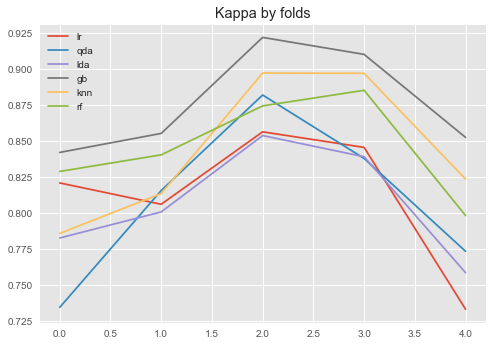

In [34]:
for name, scores in scores_dict.items():
    plt.plot(scores, label=name)
    print("Mean Kappa score for {} is : {}".format(name, np.mean(scores)))
plt.legend(loc=0)
plt.title('Kappa by folds');

In [37]:
skf = StratifiedShuffleSplit(test_size=0.3, random_state=147, n_splits=1)
for train_index, test_index in skf.split(X=df_data[pr_f], y=df_data['support'].values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df_data.loc[train_index, pr_f], df_data.loc[test_index, pr_f]
    y_train, y_test = df_data.loc[train_index, 'phase'], df_data.loc[test_index, 'phase']

TRAIN: [ 9939 12539  5481 ...,   207 14690  7938] TEST: [ 6921 17002 23234 ..., 18633  2360 23462]


In [38]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5))  
])

In [39]:
model_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('std_sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [40]:
proba = model_pipe.predict_proba(X_test)

pred = model_pipe.predict(X_test)

In [41]:
accuracy_score(y_pred=pred, y_true=y_test)

0.94409937888198758

In [42]:
cohen_kappa_score(y1=y_test, y2=pred)

0.92744231218403306

In [43]:
print(classification_report(y_pred=pred, y_true=y_test))

               precision    recall  f1-score   support

           ds       0.90      0.85      0.87      1077
heel_strike_r       0.86      0.90      0.88       594
          lss       0.97      0.97      0.97      2047
          rss       0.96      0.97      0.96      2030
    toe_off_r       0.96      0.96      0.96      1658

  avg / total       0.94      0.94      0.94      7406



In [66]:
cm = pd.DataFrame(confusion_matrix(y_pred=pred, y_true=y_test))
cm.columns = ['ds', 'hs', 'lss', 'rss', 'to']
cm.index = ['ds', 'hs', 'lss', 'rss', 'to']

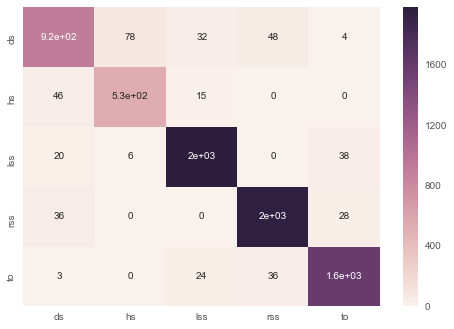

In [84]:
sns.heatmap(cm, annot=True);

In [54]:
gb = model_pipe.steps[-1][1]

feat_imp = pd.DataFrame([X_train.columns.tolist(), gb.feature_importances_.tolist()]).T
feat_imp.columns = ['feat', 'imp']
feat_imp.sort_values('imp', ascending=False, inplace=True)

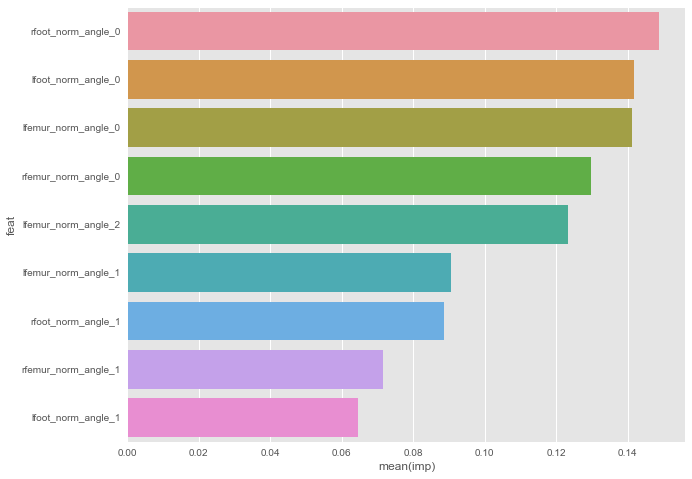

In [55]:
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp, y='feat', x='imp', orient='h');

In [56]:
joblib.dump(filename='../output/phase_norm_toes.pkl', value=model_pipe)

['../output/phase_norm_toes.pkl']

Stratified KFold for best model

In [6]:
df_data = pd.read_csv('../output/phase_toes_norm_data.csv', index_col=0)

id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r', 'phase']

pr = list(set(df_data.columns.tolist()) - set(id_target_cols))

In [12]:
skf = StratifiedKFold(n_splits=7, random_state=147, shuffle=True)

model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5))  
])

all_res = pd.DataFrame()
conf_m = pd.DataFrame()
feat_i = pd.DataFrame()

In [13]:
i = 0
for train_index, test_index in skf.split(X=df_data[pr], y=df_data['support'].values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df_data.loc[train_index, pr], df_data.loc[test_index, pr]
    y_train, y_test = df_data.loc[train_index, 'phase'], df_data.loc[test_index, 'phase']
    model_pipe.fit(X_train, y_train)
    proba = model_pipe.predict_proba(X_test)
    pred = model_pipe.predict(X_test)
    clas_r = classification_report(y_pred=pred, y_true=y_test).split()[-4:-1] 
    metr = {
        'accuracy': accuracy_score(y_pred=pred, y_true=y_test),
        'kappa': cohen_kappa_score(y1=y_test, y2=pred),
        'precision': clas_r[0],
        'recall': clas_r[1], 
        'f1': clas_r[2]
    }
    all_res = pd.concat([all_res, pd.DataFrame([metr])])
    
    cm = pd.DataFrame(confusion_matrix(y_pred=pred, y_true=y_test))
    cm.columns = ['ds', 'hs', 'lss', 'rss', 'to']
    cm.index = ['ds', 'hs', 'lss', 'rss', 'to']
    cm['fold'] = i
    conf_m = pd.concat([conf_m, cm])
    
    gb = model_pipe.steps[-1][1]
    feat_imp = pd.DataFrame([X_train.columns.tolist(), gb.feature_importances_.tolist()]).T
    feat_imp.columns = ['feat', 'imp']
    feat_imp['fold'] = i
    feat_i = pd.concat([feat_i, feat_imp])
    
    i = i + 1

TRAIN: [    1     2     3 ..., 24682 24683 24684] TEST: [    0     6     8 ..., 24671 24675 24676]
TRAIN: [    0     1     2 ..., 24681 24683 24684] TEST: [   11    14    16 ..., 24657 24662 24682]
TRAIN: [    0     2     3 ..., 24682 24683 24684] TEST: [    1    10    12 ..., 24645 24665 24681]
TRAIN: [    0     1     2 ..., 24681 24682 24684] TEST: [   31    35    37 ..., 24673 24678 24683]
TRAIN: [    0     1     2 ..., 24682 24683 24684] TEST: [    7     9    15 ..., 24672 24674 24679]
TRAIN: [    0     1     2 ..., 24681 24682 24683] TEST: [    3     4     5 ..., 24666 24680 24684]
TRAIN: [    0     1     3 ..., 24682 24683 24684] TEST: [    2    18    20 ..., 24647 24658 24677]


In [14]:
all_res['f1'] = all_res['f1'].astype('float32')
all_res['precision'] = all_res['precision'].astype('float32')
all_res['recall'] = all_res['recall'].astype('float32')

In [16]:
all_res.mean()

accuracy     0.947498
f1           0.948571
kappa        0.931822
precision    0.948571
recall       0.948571
dtype: float64

In [31]:
phases_nm = ['ds', 'hs', 'lss', 'rss', 'to']
phases_nm_1 = [ph  + "_r" for ph in phases_nm]
conf_m['n_truth'] = conf_m[phases_nm].sum(axis=1)

conf_m.reset_index(inplace=True)

In [86]:
all_cols = copy.deepcopy(phases_nm)
all_cols.append('n_truth')

In [93]:
agg_conf_m = conf_m.groupby('index')[all_cols].sum()

In [94]:
for ph in phases_nm:
    agg_conf_m[ph + "_r"] = agg_conf_m[ph] / agg_conf_m['n_truth']
agg_conf_m = agg_conf_m[phases_nm_1]

In [104]:
agg_conf_m.columns = ['ds', 'hs', 'lss', 'rss', 'to']

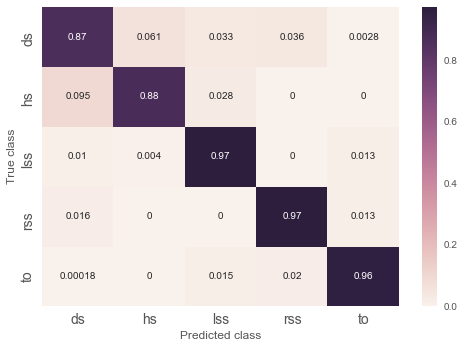

In [106]:
sns.heatmap(agg_conf_m, annot=True)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [81]:
feat_i.drop(['med_imp_x','med_imp_y'], inplace=True)

In [71]:
feat_i['imp'] = feat_i['imp'].astype('float32')

In [76]:
med_imp = feat_i.groupby('feat')['imp'].median()
med_imp = pd.DataFrame(med_imp)
med_imp.columns = ['med_imp']

In [82]:
feat_i = pd.merge(feat_i, med_imp, left_on='feat', right_index=True)
feat_i.sort_values('med_imp', inplace=True, ascending=False)

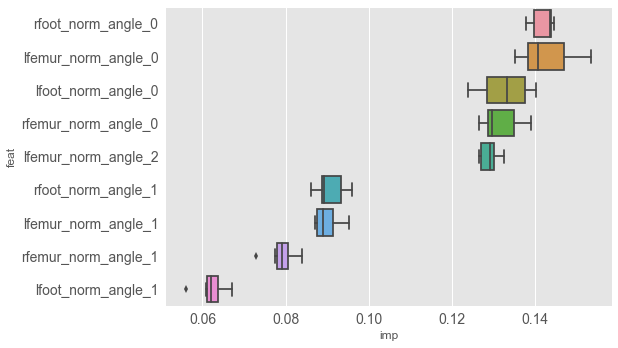

In [101]:
sns.boxplot(data=feat_i, x='imp', y='feat')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);